In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import shutil
import copy

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [2]:
path = os.path.dirname(os.getcwd())
os.chdir(path)
from Emulator.Classes.AllData import AllData
from Emulator.Classes.LightCurve import utkarshGrid, LightCurve
from Emulator.Classes.GP import GP
from Emulator.Classes.GP2D import GP2D
from Emulator.Classes.GP5D import GP5D
os.chdir(os.getcwd() + "/Emulator")
print(os.getcwd())
curr_wv = np.arange(100, 3600, 10)
set_skip_factor = None
gpSplit = 1

/Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator


In [3]:
mejdyn = 0.005 #0.01
mejwind =  0.05 #0.13
phi = 45 #90
iobs = 8 #1
mejdyn2 = copy.deepcopy(mejdyn)
mejwind2 = copy.deepcopy(mejwind)
phi2 = copy.deepcopy(phi)
iobs2 = copy.deepcopy(iobs)

gp = GP5D("Classes/reference.csv")
gp.delete_folder_files("data/pcaComponents")
gp.delete_folder_files("data/pcaComponentsTrained")
gp.delete_folder_files("data/pcaComponentsTrainedError")
gp.delete_folder_files("data/pcaTrained")
gp.delete_folder_files("data/pcaTrainedUpper")
gp.delete_folder_files("data/pcaTrainedLower")
# gp.split = gpSplit
# gp.emulator = "start"
gp.cross_validation = (mejdyn, mejwind, phi, iobs)
gp.set_wv_range(curr_wv)
# gp.n_comp = 25
# time_shape = None

In [4]:
data_matrix = np.zeros((100, 350, 0), dtype = float)
data_matrix.shape

(100, 350, 0)

In [5]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [6]:
# from tqdm import tqdm
# self = gp
# for index, row, in tqdm(self.reference.iterrows(), total = len(self.reference)):
#     for viewing_angle in self.iobs_range:
#         pca_matrix = np.load(
#             f"data/pca/mejdyn{row.mejdyn}_mejwind{row.mejwind}_phi{row.phi}_iobs{viewing_angle}.npy")
#         data_matrix = np.append(data_matrix, np.expand_dims(pca_matrix, axis = 2), axis = 2)

In [7]:
# Creating a PyTorch class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.kernel_size = 1
        self.activation_function = torch.nn.ReLU()
          

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(350, 200, kernel_size = self.kernel_size, stride=1),
            self.activation_function,
            torch.nn.Conv1d(200, 50, kernel_size = self.kernel_size, stride=1),
            torch.nn.Flatten(), 
            self.activation_function, 
            torch.nn.Linear(50,25))
        
        self.decoder = torch.nn.Sequential(
            self.activation_function, 
            torch.nn.Linear(25,50),
            torch.nn.Unflatten(1, (50,1)),
            torch.nn.ConvTranspose1d(50, 200, kernel_size=self.kernel_size, stride=1),
            self.activation_function,
            torch.nn.ConvTranspose1d(200, 350, kernel_size=self.kernel_size, stride=1))
      
    def backward(self, inpt):
        return self.encoder(inpt)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
data_matrix = np.load(f"data/transformComponents/full_data.npy")

# Model Initialization
modelAE = AE()
  
# Validation using Loss function
loss_function = torch.nn.MSELoss(reduction='mean')
  
# Using an Adam Optimizer
optimizer = torch.optim.Adam(modelAE.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-9)

100%|██████████| 21/21 [00:00<00:00, 88.73it/s]


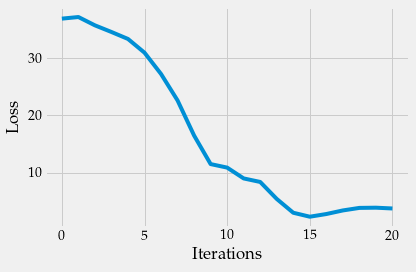

In [9]:
from tqdm import tqdm
outputs = []
losses = []
for i in tqdm(range(21)):
    single_mat = torch.tensor(data_matrix[:,:,i]).float()
    image = single_mat
    image = image.unsqueeze(2)

    weights = modelAE.encoder(image)
    reconstructed = modelAE.decoder(weights)
    
    # Calculating the loss function
    loss = loss_function(reconstructed, image)

    # The gradients are set to zero,
    # the the gradient is computed and stored.
    # .step() performs parameter update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Storing the losses in a list for plotting
    losses.append(loss)


plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)




In [10]:
from time import perf_counter
matrix_to_decode = torch.tensor(data_matrix[:,:,-4]).float().unsqueeze(-1)
weights = modelAE.encoder(matrix_to_decode)
t0 = perf_counter()
reconstructed_pre = modelAE.decoder(weights)
reconstructed = reconstructed_pre.reshape(-1, 100,350)
t1 = perf_counter()
print(weights.shape)
print(f"Took {round(1e3*(t1- t0), 4)}ms")
print(loss_function(reconstructed_pre, matrix_to_decode))
weights = weights.detach().numpy()
reconstructed_numpy = reconstructed.detach().numpy()
mse = np.square(np.subtract(data_matrix[:,:,-4], reconstructed_numpy)).mean()
print("Manual",mse)

# print(matrix_to_decode, reconstructed)

torch.Size([100, 25])
Took 2.7608ms
tensor(6.9564, grad_fn=<MseLossBackward>)
Manual 6.956397316247713


In [11]:
weights.shape

(100, 25)

In [12]:
# # Trying Manual PCA
# Now lets encode and decode a sample matrix
single_mat = data_matrix[:,:,-1]
X = single_mat
mu = np.mean(X, axis = 0)
X_meaned = X - mu
V = np.cov(X_meaned, rowvar = False)
eigen_values, eigen_vectors = np.linalg.eig(V)
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:,sorted_index]
n_components_x = 20
eigenvector_subset = sorted_eigenvectors[:,:n_components_x]
X_reduced = (eigenvector_subset.T@X_meaned.T).T
Y = X_reduced
mu_y = np.mean(Y, axis = 0)
Y_meaned = Y - mu_y
V_y = np.cov(Y_meaned)
eigen_values_y, eigen_vectors_y = np.linalg.eig(V_y)
sorted_index_y = np.argsort(eigen_values_y)[::-1]
sorted_eigenvalue_y = eigen_values_y[sorted_index_y]
sorted_eigenvectors_y = eigen_vectors_y[:,sorted_index_y]
n_components_y = 20
eigenvector_subset_y = sorted_eigenvectors_y[:,:n_components_y]
Y_reduced_approximate = (eigenvector_subset_y.T@Y_meaned)

# single_mat = data_matrix[:,:,-1]
# X = single_mat
# mu = np.mean(X, axis = 0)
# X_meaned = X - mu
# V = np.cov(X_meaned, rowvar = False)
# eigen_values, eigen_vectors = np.linalg.eig(V)
# sorted_index = np.argsort(eigen_values)[::-1]
# sorted_eigenvalue = eigen_values[sorted_index]
# sorted_eigenvectors = eigen_vectors[:,sorted_index]
# n_components_x = 10
# eigenvector_subset = sorted_eigenvectors[:,:n_components_x]
# X_reduced = (eigenvector_subset.T@X_meaned.T).T
# Y = X_reduced
# mu_y = np.mean(Y, axis = 0)
# Y_meaned = Y - mu_y
# V_y = np.cov(Y_meaned)
# eigen_values_y, eigen_vectors_y = np.linalg.eig(V_y)
# sorted_index_y = np.argsort(eigen_values_y)[::-1]
# sorted_eigenvalue_y = eigen_values_y[sorted_index_y]
# sorted_eigenvectors_y = eigen_vectors_y[:,sorted_index_y]
# n_components_y = 10
# eigenvector_subset_y = sorted_eigenvectors_y[:,:n_components_y]
# Y_reduced_true = (eigenvector_subset_y.T@Y_meaned)

# Reconstruction
X_reduced = (Y_reduced_approximate.T@eigenvector_subset_y.T).T + mu_y
X_reconstructed = X_reduced@eigenvector_subset.T + mu
X_reconstructed = np.real(X_reconstructed)
mse = np.square(np.subtract(X, X_reconstructed)).mean()

print(X.shape)
print(Y.shape)
print(Y_reduced_approximate.shape)
print(X_reduced.shape)
print(X_reconstructed.shape)
mse

(100, 350)
(100, 20)
(20, 20)
(100, 20)
(100, 350)


0.017225716220475244

In [13]:
# from sklearn.decomposition import PCA
# from scipy import linalg
# print(data_matrix.shape)
# U, s, V = linalg.svd(data_matrix)




# # pca = PCA(n_components=50, svd_solver='randomized')
# # pca.fit(data_matrix)
# # reduced_data = pca.transform(data_matrix)
# # print(reduced_data.shape)
# # pre_trained_comp = pca.components_[:, counter]
# # post_trained_comp = pre_trained_comp #TRAINED COMPONENTS
# # trained1 = np.dot(reduced_data, post_trained_comp)
# # print(trained1.shape)

In [14]:
x = []
for index, row, in tqdm(gp.reference.iterrows(), total = len(gp.reference)):
    for viewing_angle in gp.iobs_range:
        x.append([row.mejdyn, row.mejwind, row.phi, viewing_angle])

100%|██████████| 196/196 [00:00<00:00, 2355.96it/s]


In [15]:
# Truncate for optical
n = 100
nt = 50
print(gp.wv_range[:n])
t = np.arange(0, 20, 20 / (gp.Ntime[2]))
print(t[:nt])
pre = data_matrix[:nt,:n,:]
pre.shape

[ 100  110  120  130  140  150  160  170  180  190  200  210  220  230
  240  250  260  270  280  290  300  310  320  330  340  350  360  370
  380  390  400  410  420  430  440  450  460  470  480  490  500  510
  520  530  540  550  560  570  580  590  600  610  620  630  640  650
  660  670  680  690  700  710  720  730  740  750  760  770  780  790
  800  810  820  830  840  850  860  870  880  890  900  910  920  930
  940  950  960  970  980  990 1000 1010 1020 1030 1040 1050 1060 1070
 1080 1090]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 6.8 7.
 7.2 7.4 7.6 7.8 8.  8.2 8.4 8.6 8.8 9.  9.2 9.4 9.6 9.8]


(50, 100, 2156)

In [16]:
pre.shape
ncomp_x = 100
ncomp_y = 50
A_ = np.empty((ncomp_y, ncomp_x, pre.shape[2]))
A_[:] = np.nan

for i in tqdm(range(pre.shape[2])):
    curr = list(x[i])
    single_mat = pre[:nt,:n,i]
    X = single_mat
    mu = np.mean(X, axis = 0)
    X_meaned = X - mu
    V = np.cov(X_meaned, rowvar = False)
    eigen_values, eigen_vectors = np.linalg.eig(V)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    n_components_x = ncomp_x
    eigenvector_subset = sorted_eigenvectors[:,:n_components_x]
    X_reduced = (eigenvector_subset.T@X_meaned.T).T
    Y = X_reduced
    mu_y = np.mean(Y, axis = 0)
    Y_meaned = Y - mu_y
    V_y = np.cov(Y_meaned)
    eigen_values_y, eigen_vectors_y = np.linalg.eig(V_y)
    sorted_index_y = np.argsort(eigen_values_y)[::-1]
    sorted_eigenvalue_y = eigen_values_y[sorted_index_y]
    sorted_eigenvectors_y = eigen_vectors_y[:,sorted_index_y]
    n_components_y = ncomp_y
    eigenvector_subset_y = sorted_eigenvectors_y[:,:n_components_y]
    Y_reduced_approximate = np.real(eigenvector_subset_y.T@Y_meaned)
    A_[:,:,i] = Y_reduced_approximate
    
    if curr == list(gp.cross_validation):
        true_reduced = Y_reduced_approximate
        change_of_basis_y = eigenvector_subset_y
        mean_y = mu_y
        change_of_basis_x = eigenvector_subset
        mean_x = mu
        print(list(curr))
        print("Saved change of basis for cross validation.")
        

print(A_.shape)

 28%|██▊       | 614/2156 [00:02<00:07, 215.14it/s]

[0.005, 0.05, 45, 8]
Saved change of basis for cross validation.


100%|██████████| 2156/2156 [00:10<00:00, 212.33it/s]

(50, 100, 2156)


In [17]:
A = A_.reshape(ncomp_x*ncomp_y, 2156)
med = np.median(A)
A = A/med - 1
B = (A+1)*med
B = B.reshape(ncomp_y, ncomp_x, 2156)
assert np.allclose(B, A_)

In [18]:
gp.X = np.array(x, dtype = float)
gp.Y = A.T
gp.kernel = GPy.kern.RBF(input_dim=4, ARD = True) * GPy.kern.Linear(input_dim = 4,ARD=True)
gp.model = GPy.models.GPRegression(gp.X,gp.Y,gp.kernel)
# gp.model.mul.rbf.lengthscale[[0]].constrain_bounded(0,1) 
# gp.model.mul.rbf.lengthscale[[1]].constrain_bounded(0,1) 
# gp.model.mul.rbf.lengthscale[[2]].constrain_bounded(0,1)  
# gp.model.mul.rbf.lengthscale[[3]].constrain_bounded(0,1)
gp.model.optimize(messages=True, max_iters = 100)

In [19]:
display(gp.model.mul.rbf.lengthscale)
# display(gp.model.mul.Mat32.lengthscale)
# # display(gp.model.mul.ExpQuad.lengthscale)
display(gp.model.mul.linear.variances)

index,GP_regression.mul.rbf.lengthscale,constraints,priors
[0],0.00000000,+ve,
[1],0.00000013,+ve,
[2],1.00000000,+ve,
[3],0.80755215,+ve,


index,GP_regression.mul.linear.variances,constraints,priors
[0],1.00074242,+ve,
[1],1.02590457,+ve,
[2],5.59274876,+ve,
[3],4.21307486,+ve,


In [20]:
def gpFake(mejdyn, mejwind, phi, iobs):
    self = gp
    
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    
    mejdyn = find_nearest(gp.reference.mejdyn.unique(), mejdyn)
    mejwind = find_nearest(gp.reference.mejwind.unique(), mejwind)
    phi = find_nearest(gp.reference.phi.unique(), phi)
    iobs = find_nearest(np.arange(0, 11, 1), iobs)
#     print("\n",[mejdyn, mejwind, phi, iobs])
    truth_matrix = np.load(f"data/pca/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
    truth_matrix = truth_matrix[:nt,:n]
    assert truth_matrix.shape == (nt, n)
    return np.expand_dims(truth_matrix, axis = 2)

In [21]:
predX = np.expand_dims(np.array(list(gp.cross_validation)), axis = 1).T
print(predX)
t0 = time.time()
predY, varY = gp.model.predict(predX)
predY = (predY+1)*med
predY = predY.reshape(ncomp_y, ncomp_x)
print((time.time()-t0)*100,"ms")

[[5.0e-03 5.0e-02 4.5e+01 8.0e+00]]
0.803375244140625 ms


In [22]:
predX = np.expand_dims(np.array(list(gp.cross_validation)), axis = 1).T
X_reduced = (true_reduced.T@change_of_basis_y.T).T + mean_y
X_reconstructed = X_reduced@change_of_basis_x.T + mean_x
purePCA = np.expand_dims(np.real(X_reconstructed), axis = 2)
pureMSE = np.square(np.subtract(gpFake(*list(predX.squeeze())), purePCA)).mean()
print(pureMSE)


X_reduced = (predY.T@change_of_basis_y.T).T + mean_y
X_reconstructed = X_reduced@change_of_basis_x.T + mean_x
predYPCA = np.expand_dims(np.real(X_reconstructed), axis = 2)
mse = np.square(np.subtract(gpFake(*list(predX.squeeze())), predYPCA)).mean()
print(mse)

7.670271335610473e-27
1.9148181341081977e-07


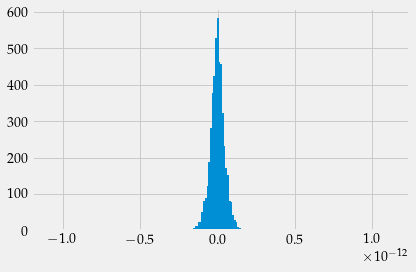

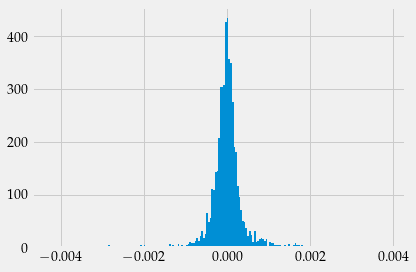

In [23]:
plt.figure()
diff = np.subtract(gpFake(*list(predX.squeeze())), purePCA).flatten()
plt.hist(diff, bins = 200)
# plt.xlim(-5,5)
plt.show()
plt.figure()
diff = np.subtract(gpFake(*list(predX.squeeze())), predYPCA).flatten()
plt.hist(diff, bins = 200)
# plt.xlim(-5,5)
plt.show()

In [24]:
# Uninformative Prior
def log_prior(theta):
    mejdyn, mejwind, phi, iobs = theta
    if mejdyn > 0.2 or mejdyn < 0:
        ret = -np.inf
    elif mejwind > 0.2 or mejwind < 0:
        ret = -np.inf
    elif phi > 90.0 or phi < 0:
        ret = -np.inf
    elif iobs > 12.0 or iobs < 0:
        ret = -np.inf
    else:
        ret = 0
    return ret

In [25]:
def reduce(gpfake, mean_y = mean_y, mean_x = mean_x, change_of_basis_y = change_of_basis_y, change_of_basis_x = change_of_basis_x):
    pre_y = gpfake # THIS IS OUR "MOCK DATA"
    single_mat = pre_y.squeeze()
    X = single_mat
    mu = np.mean(X, axis = 0)
    X_meaned = X - mu
    V = np.cov(X_meaned, rowvar = False)
    eigen_values, eigen_vectors = np.linalg.eig(V)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    n_components_x = ncomp_x
    eigenvector_subset = sorted_eigenvectors[:,:n_components_x]
    X_reduced = (eigenvector_subset.T@X_meaned.T).T
    Y = X_reduced
    mu_y = np.mean(Y, axis = 0)
    Y_meaned = Y - mu_y
    V_y = np.cov(Y_meaned)
    eigen_values_y, eigen_vectors_y = np.linalg.eig(V_y)
    sorted_index_y = np.argsort(eigen_values_y)[::-1]
    sorted_eigenvalue_y = eigen_values_y[sorted_index_y]
    sorted_eigenvectors_y = eigen_vectors_y[:,sorted_index_y]
    n_components_y = ncomp_y
    eigenvector_subset_y = sorted_eigenvectors_y[:,:n_components_y]
    Y_reduced_approximate = np.real(eigenvector_subset_y.T@Y_meaned)
    
    # Reconstruction
    X_reduced = (Y_reduced_approximate.T@eigenvector_subset_y.T).T + mu_y
    X_reconstructed = X_reduced@eigenvector_subset.T + mu
    y = np.expand_dims(np.real(X_reconstructed), axis = 2)
    return y

In [26]:
# Squared Error Negative Log-Like (Assuming Gaussian Likelihood)
# def loglike(theta, y, yerr):
#     mejdyn, mejwind, phi, iobs = theta
#     y_model = reduce(gpFake(mejdyn, mejwind, phi, iobs))
#     yerr_new = yerr
#     logl = - 0.5 * np.sum(((y - y_model) / yerr_new) ** 2)  #+ np.log(2 * np.pi * yerr)
#     return logl

def loglike(theta, y, yerr, med = med, ncomp_y = ncomp_y, ncomp_x = ncomp_x, 
            change_of_basis_y = change_of_basis_y, change_of_basis_x = change_of_basis_x, 
           mean_y = mean_y, mean_x = mean_x):
    mejdyn, mejwind, phi, iobs = theta
    y_model, y_var = gp.model.predict(np.expand_dims(np.array(list(theta)), axis = 1).T)
    y_model = (y_model+1)*med
    y_var = (y_var+1)*(med**2) 
    reduced = y_model.reshape(ncomp_y, ncomp_x)
    X_reduced = (reduced.T@change_of_basis_y.T).T + mean_y
    X_reconstructed = X_reduced@change_of_basis_x.T + mean_x
    y_model = np.expand_dims(np.real(X_reconstructed), axis = 2)
    yerr = 0.001*y
    yerr_new = np.sqrt(yerr ** 2 + y_var**2)
#     yerr_new = yerr
    logl = - 0.5 * np.sum(((y - y_model) / yerr_new) ** 2)  #+ np.log(2 * np.pi * yerr)
    return logl

In [27]:
def logpost(theta, y, yerr):
    logp = log_prior(theta)  # prior
    logl = loglike(theta, y, yerr)  # likelihood
    ret =  logl + logp  # posterior
    ret = ret.squeeze()
#     print(ret, theta)
    return ret

In [28]:
# pre_y = gpFake(*list(predX.squeeze())) # THIS IS OUR "MOCK DATA"
# print(pre_y.shape)
# single_mat = pre_y.squeeze()
# X = single_mat
# mu = np.mean(X, axis = 0)
# X_meaned = X - mu
# V = np.cov(X_meaned, rowvar = False)
# eigen_values, eigen_vectors = np.linalg.eig(V)
# sorted_index = np.argsort(eigen_values)[::-1]
# sorted_eigenvalue = eigen_values[sorted_index]
# sorted_eigenvectors = eigen_vectors[:,sorted_index]
# n_components_x = ncomp_x
# eigenvector_subset = sorted_eigenvectors[:,:n_components_x]
# X_reduced = (eigenvector_subset.T@X_meaned.T).T
# Y = X_reduced
# mu_y = np.mean(Y, axis = 0)
# Y_meaned = Y - mu_y
# V_y = np.cov(Y_meaned)
# eigen_values_y, eigen_vectors_y = np.linalg.eig(V_y)
# sorted_index_y = np.argsort(eigen_values_y)[::-1]
# sorted_eigenvalue_y = eigen_values_y[sorted_index_y]
# sorted_eigenvectors_y = eigen_vectors_y[:,sorted_index_y]
# n_components_y = ncomp_y
# eigenvector_subset_y = sorted_eigenvectors_y[:,:n_components_y]
# Y_reduced_approximate = np.real(eigenvector_subset_y.T@Y_meaned)
# y = Y_reduced_approximate
# yerr = 0.0001*y
# print(y.shape)

In [29]:
truth = np.copy(list(predX.flatten()))
y = reduce(gpFake(*list(predX.flatten()))) # MOCK DATA
err = 0.001*y

print(logpost(truth, y, 0.01*y))
print(logpost([0.005,0.05,45.0, 7.99], y, err))
print(logpost([0.005,0.05,45.0, 7.8], y, err))
print(logpost([0.005,0.05,45.0, 7.5], y, err))
print(logpost([0.005,0.05,45.0, 7.0], y, err))
print(logpost([0.005,0.05,45.0, 6.0], y, err)) # Should be futher and further from 0
print(logpost([0.005,0.05,45.0, 5.0], y, err))
print(logpost([0.005,0.05,45.0, 4.0], y, err))
print(logpost([0.005,0.05,45.0, 3.0], y, err))
print(logpost([0.005,0.05,45.0, 2.0], y, err))
print(logpost([0.005,0.05,45.0, 1.0], y, err))
print()
print(logpost([0.005,0.05,45.0, 8.0], y, err))
print(logpost([0.005,0.05,45.0, 8.03], y, err))
print(logpost([0.005,0.05,45.0, 8.2], y, err))
print(logpost([0.005,0.05,45.0, 9.0], y, err))
print(logpost([0.005,0.05,45.0, 10.0], y, err))
print()
print(logpost(truth, y, 0.01*y))
print(logpost([0.005,0.05,50.0, 8.0], y, err))
print(logpost([0.005,0.05,60.0, 8.0], y, err)) # Should be futher and further from 0
print(logpost([0.005,0.05,75.0, 8.0], y, err))
print(logpost([0.005,0.05,90.0, 8.0], y, err))
print()
print(logpost(truth, y, 0.01*y))
print(logpost([0.005,0.05,60.0, 7.0], y, err))

-25.047186370356467
-1080.3109960487661
-404969.2459021356
-2381355.545728297
-10181366.081539381
-11209650.083094954
-63842405.39168533
-62857147.28409463
-64306924.58647775
-64048887.66113104
-63480774.848250575

-25.047186370356467
-11828.697801564922
-528678.7062523281
-5622590.1631891485
-66690169.47951242

-25.047186370356467
-221565206.2793513
-7063582.206994217
-66447389.513160996
-60477774.72927938

-25.047186370356467
-67106236.9895096


In [30]:
X_reduced = (true_reduced.T@change_of_basis_y.T).T + mean_y
X_reconstructed = X_reduced@change_of_basis_x.T + mean_x
y = np.expand_dims(np.real(X_reconstructed), axis = 2)
yerr = 0.001*y

In [31]:
import emcee

nburn = 100
nwalkers = 100
ndim = 4
initial = np.array([0.001, 0.005, 15, 1]) # Arbitary point

scale = 0.3
p0_mejdyn = [np.array(initial)[0] + 1e-2 * scale * np.random.rand(nwalkers)]
p0_mejwind = [np.array(initial)[0] + 1e-1 * scale * np.random.rand(nwalkers)]
p0_phi = [np.array(initial)[0] + 10 * scale * np.random.rand(nwalkers)]
p0_iobs = [np.array(initial)[0] + 5 * scale * np.random.rand(nwalkers)]
p0 = np.array([p0_mejdyn, p0_mejwind, p0_phi, p0_iobs], dtype=float)
p0 = p0.squeeze().T   

print("Truth", list(truth))
print("Initial", list(initial))


sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=[y, yerr], 
                                moves=[(emcee.moves.StretchMove(), 0.5),
                                       (emcee.moves.KDEMove(), 0.5),])
print("Started Burn-In")
t0 = time.time()
state = sampler.run_mcmc(p0, nburn, progress=True)
print(f"Burn-In Took: {round((time.time() - t0) / 60, 4)}mins")
sampler.reset()

Truth [0.005, 0.05, 45.0, 8.0]
Initial [0.001, 0.005, 15.0, 1.0]
Started Burn-In


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]

Burn-In Took: 0.7039mins


In [32]:
niter = 150
state = sampler.run_mcmc(state, niter, progress=True)

100%|██████████| 150/150 [01:04<00:00,  2.34it/s]


Truth [0.005, 0.05, 45.0, 8.0]
Initial [0.001, 0.005, 15.0, 1.0]


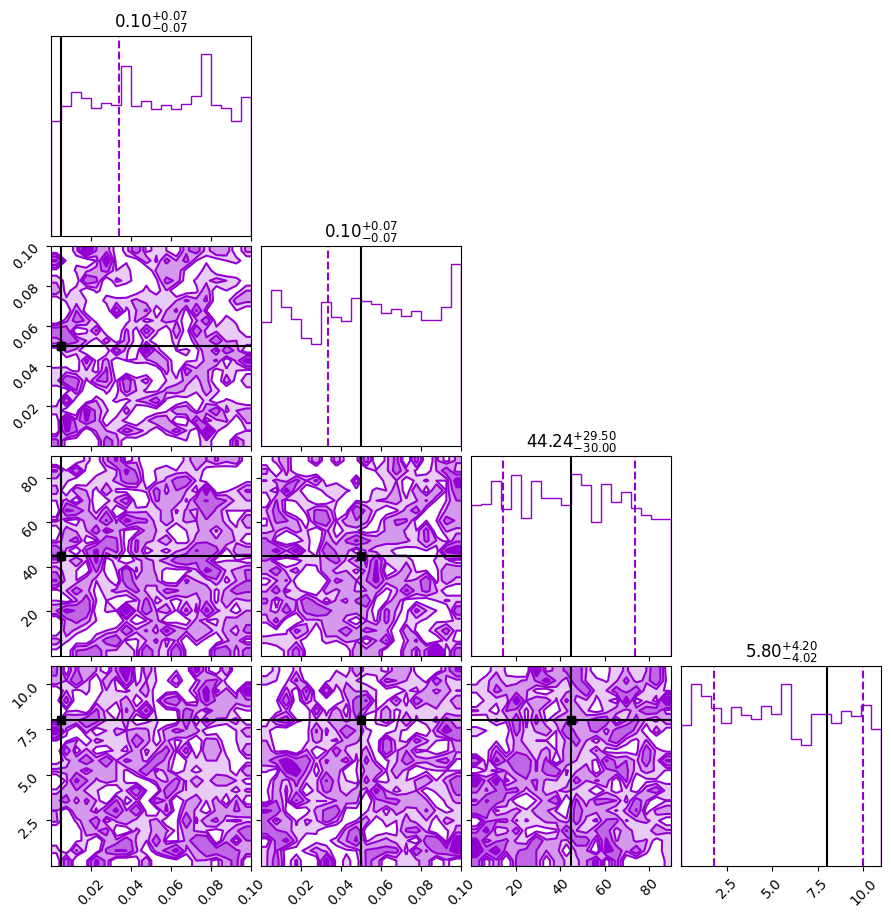

In [33]:
samples = sampler.get_chain(discard = 50)
samples = np.copy(samples)

corner_samples = samples.reshape(-1, ndim)

print("Truth", list(truth))
print("Initial", list(initial))

import corner
plt.style.use('default')
corner.corner(corner_samples,  # collect samples into N x 3 array
              bins=20,  # bins for histogram
              show_titles=True, quantiles=[0.16, 0.84],  # show median and uncertainties
              truths=truth,  # plot truth
              range = [(0,0.1),(0,0.1),(0, 90), (0,11)],
              color='darkviolet', truth_color='black',  # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})  # change some default options
plt.show()

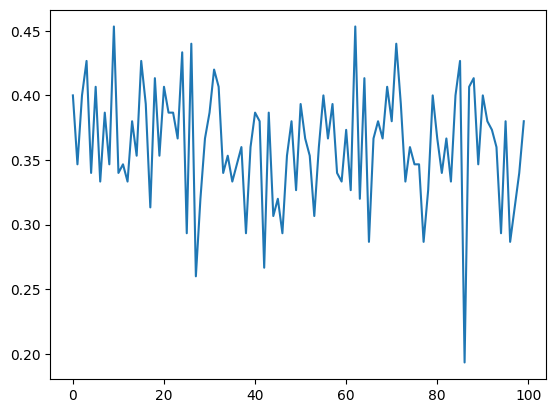

In [34]:
axis = np.arange(0, sampler.acceptance_fraction.shape[0], 1)
plt.plot(axis, sampler.acceptance_fraction)

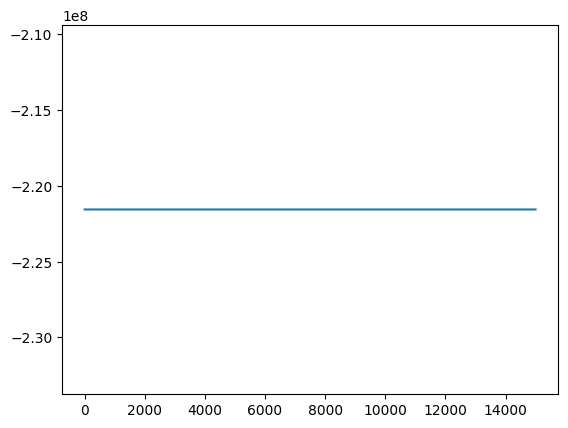

In [35]:
axis = np.arange(0, sampler.flatlnprobability.shape[0], 1)
plt.plot(axis, sampler.flatlnprobability)

(150, 100)
(150, 100)
(150, 100)
(150, 100)


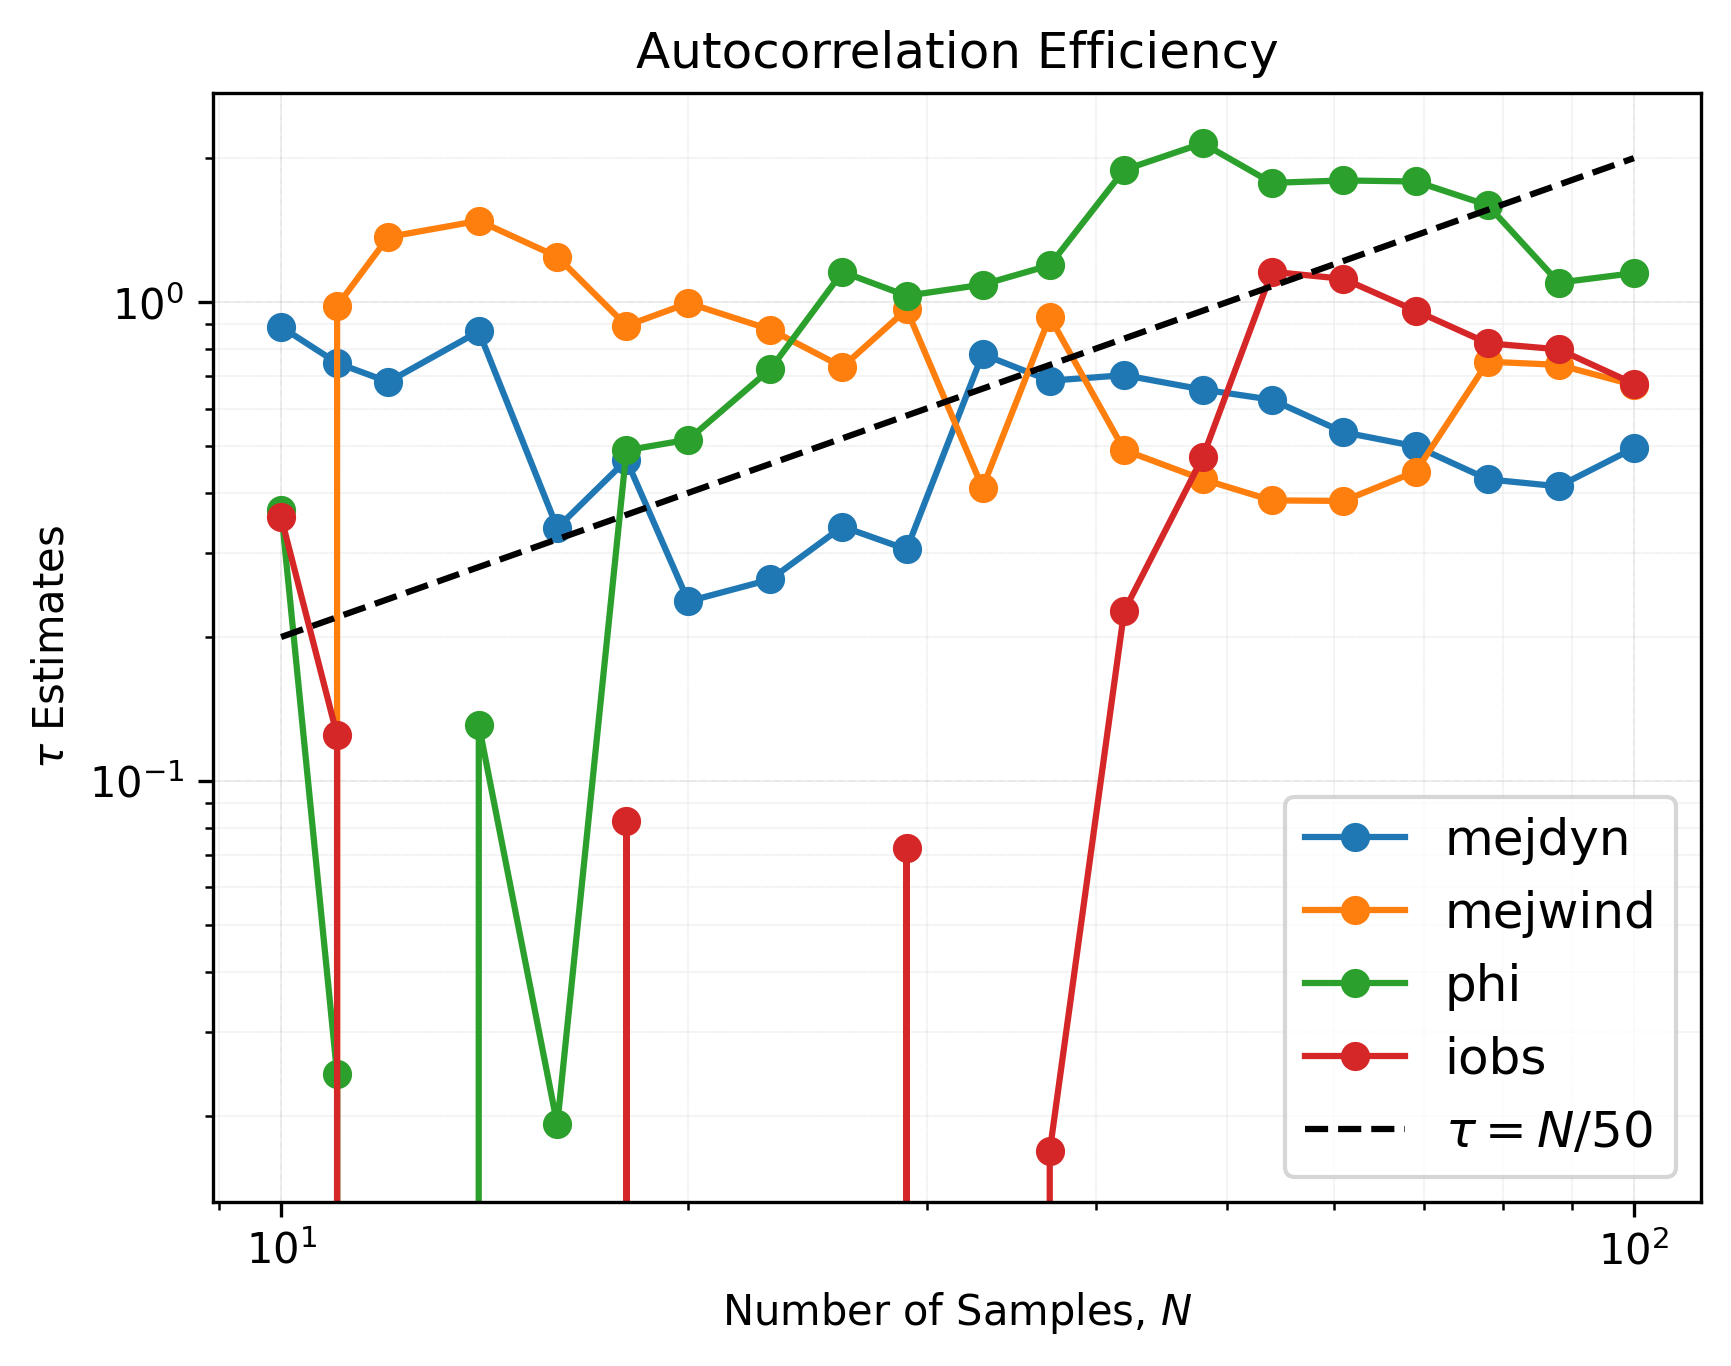

In [36]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

labs = ["mejdyn","mejwind", "phi", "iobs"]
plt.figure(dpi=300)
for dimension in range(len(initial)):
    chain = sampler.get_chain()[:, :, dimension]
    print(chain.shape)
    N = np.exp(np.linspace(np.log(10), np.log(chain.shape[1]), 20)).astype(int)

    # Compute the estimators for a few different chain lengths
    gw2010 = np.empty(len(N))
    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(chain[:,:n])

    # Plot the comparisons
    plt.loglog(N, gw2010, "o-", label=f"{labs[dimension]}")

ylim = plt.gca().get_ylim()
plt.ylim(ylim)
plt.xlabel("Number of Samples, $N$")
plt.ylabel(r"$\tau$ Estimates")
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.legend(fontsize=12)
plt.title(f"Autocorrelation Efficiency")
utkarshGrid()